# Padasip Adaptive Filters Basics - Noise Cancelation, System Identification and Signal Prediction 

This tutorial explains how to perform various tasks with adaptive filters through several examples.

Lets start with importing padasip. In the following examples we will also use numpy and matplotlib.

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pylab as plt

import padasip as pa

%matplotlib inline 
plt.style.use('ggplot') # nicer plots
np.random.seed(52102) # always use the same random seed to make results comparable
%config InlineBackend.print_figure_kwargs = {}

## Construction of Input Vectors (Input Matrix) from a Time Series

Let us consider a time series $\textbf{u}$

In [2]:
u = np.arange(0,10,1)
u

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

If the series is only an input of the adaptive filter, the input matrix can be a so called Delay Embedded Matrix (DEM). The construction of the input matrix can be simply created as

In [3]:
x = pa.input_from_history(u, 4)
x

array([[ 0.,  1.,  2.,  3.],
       [ 1.,  2.,  3.,  4.],
       [ 2.,  3.,  4.,  5.],
       [ 3.,  4.,  5.,  6.],
       [ 4.,  5.,  6.,  7.],
       [ 5.,  6.,  7.,  8.],
       [ 6.,  7.,  8.,  9.]])

In this matrix, every row represents an input vector for one sample. If you want to extend the input matrix with a bias, then

In [4]:
n = 4
x = pa.input_from_history(u, n, bias=True)
x

array([[ 0.,  1.,  2.,  3.,  1.],
       [ 1.,  2.,  3.,  4.,  1.],
       [ 2.,  3.,  4.,  5.,  1.],
       [ 3.,  4.,  5.,  6.,  1.],
       [ 4.,  5.,  6.,  7.,  1.],
       [ 5.,  6.,  7.,  8.,  1.],
       [ 6.,  7.,  8.,  9.,  1.]])

The length of the input matrix (number of rows) is
$N - n + 1$, where $N$ is the length of the time series, $n$ is the desired number of historical values in one row of the input matrix, so:

In [5]:
N = len(u)
n = 4
N - n + 1

7

is equal to

In [6]:
len(x)

7

## Noise Cancelation (Example with RLS Filter)

Consider a sin like natured signal $\textbf{u}$ contaminated with noise $\textbf{v}$. This results in a measured signal $\textbf{d}$. The goal is prediction/reconstruction of signal $\textbf{u}$ only from signal $\textbf{d}$. For the evaluation of noise cancelation performance we will use the <a href="https://en.wikipedia.org/wiki/Mean_squared_error">MSE</a> (mean-squared-error).

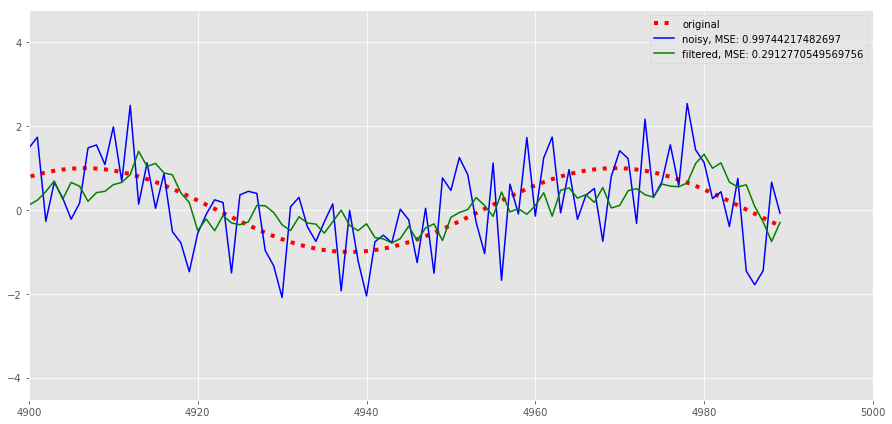

In [7]:
# signals creation: u, v, d
N = 5000
n = 10
u = np.sin(np.arange(0, N/10., N/50000.))
v = np.random.normal(0, 1, N)
d = u + v

# filtering
x = pa.input_from_history(d, n)[:-1]
d = d[n:]
u = u[n:]
f = pa.filters.FilterRLS(mu=0.9, n=n)
y, e, w = f.run(d, x)

# error estimation
MSE_d = np.dot(u-d, u-d) / float(len(u))
MSE_y = np.dot(u-y, u-y) / float(len(u))

# results
plt.figure(figsize=(12.5,6))
plt.plot(u, "r:", linewidth=4, label="original")
plt.plot(d, "b", label="noisy, MSE: {}".format(MSE_d))
plt.plot(y, "g", label="filtered, MSE: {}".format(MSE_y))
plt.xlim(N-100,N)
plt.legend()
plt.tight_layout()
plt.show()

According to this result, the adaptive filter can decrease the MSE caused by noise.

## System Identification (Example with NLMS Filter)

Consider a system output contaminated with noise $\textbf{v}$

$d(k) = 2 x_1(k) + 0.1 x_2(k) - 4 x_3(k) + 0.5 x_4(k) + v(k)$

where $x_i(k)$ is $i$-th channel (column) in $k$ sample (row) of the input matrix $\textbf{X}$ (random numbers in this example) - in this case, the input of the system is the same as the input of the filter. The noise $\textbf{v}$ is Gaussian white noise with zero mean and standard deviation of 0.1. Because the scale of the data is small, we can use a high learning rate $\mu=0.5$

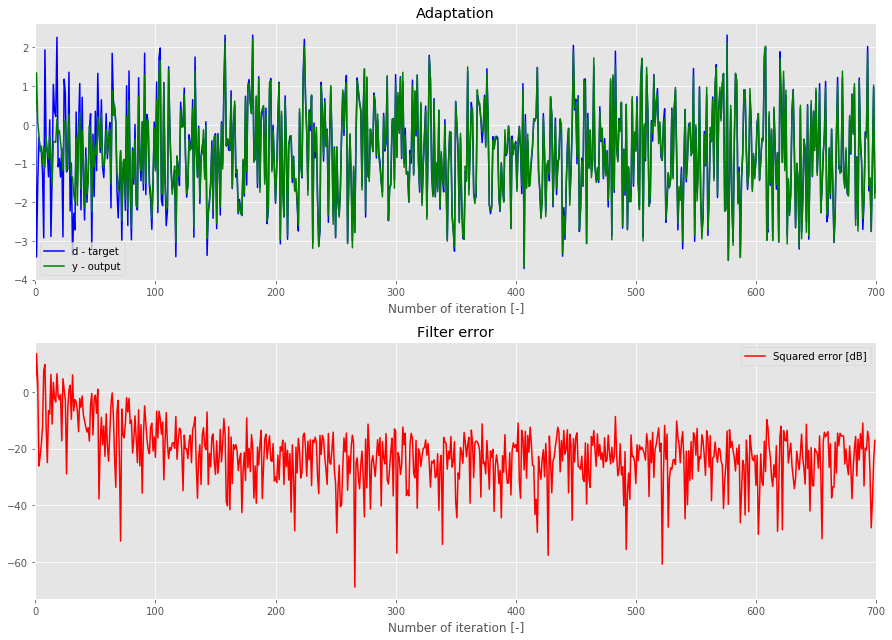

And the resulting coefficients are: [ 2.03670829  0.08079535 -4.03870081  0.49211354]


In [8]:
# creation of x and d
N = 700
x = np.random.random((N, 4))
v = np.random.normal(0, 1, N) * 0.1
d = 2*x[:,0] + 0.1*x[:,1] - 4*x[:,2] + 0.5*x[:,3] + v

# identification
f = pa.filters.FilterNLMS(mu=0.5, n=4)
y, e, w = f.run(d, x)

# show results
plt.figure(figsize=(12.5,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("Number of iteration [-]")
plt.plot(d,"b", label="d - target")
plt.plot(y,"g", label="y - output")
plt.xlim(0, N)
plt.legend()

plt.subplot(212); plt.title("Filter error"); plt.xlabel("Number of iteration [-]")
plt.plot(pa.misc.logSE(e),"r", label="Squared error [dB]");plt.legend()
plt.xlim(0, N)
plt.tight_layout()
plt.show()
print("And the resulting coefficients are: {}".format(w[-1]))

## Prediction (Example with RLS Filter)

Consider measured data produced by the following system

$d(k) = a_1 u(k) + a_2 u(k-1) + a_3 u(k-2) + a_4 u(k-3)$

For $d(0)$ we need initial conditions $[u(-3), u(-2), u(-1), u(0)]$. In other words, for $u$ of size $100$ the maximal size of $d$ is $97$.

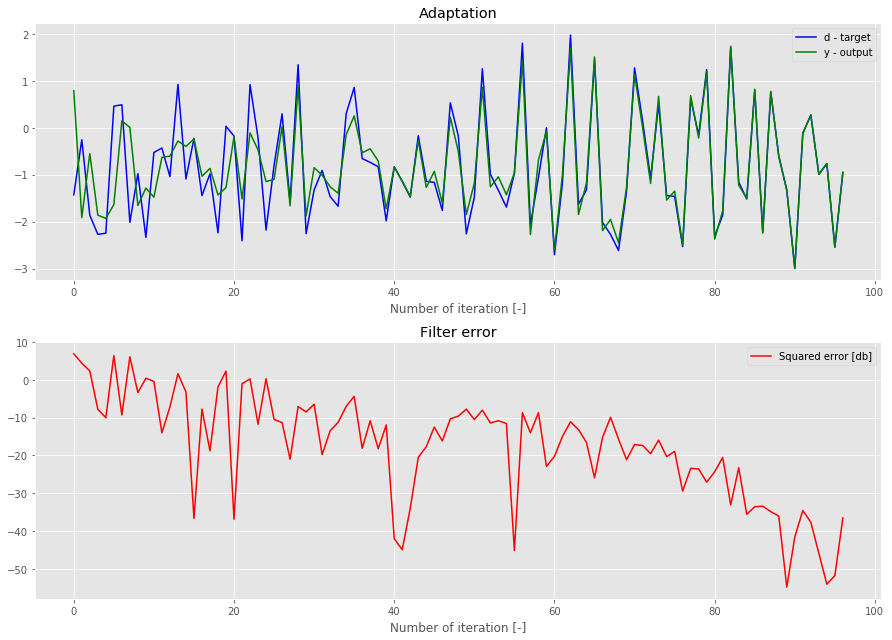

In [10]:
# creation of u, x and d
N = 100
u = np.random.random(N)
d = np.zeros(N)
for k in range(3, N):
    d[k] = 2*u[k] + 0.1*u[k-1] - 4*u[k-2] + 0.5*u[k-3]
d = d[3:]

# identification
x = pa.input_from_history(u, 4)
f = pa.filters.FilterRLS(mu=0.1, n=4)
y, e, w = f.run(d, x)

# show results
plt.figure(figsize=(12.5,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("Number of iteration [-]")
plt.plot(d,"b", label="d - target")
plt.plot(y,"g", label="y - output");plt.legend()
plt.subplot(212);plt.title("Filter error");plt.xlabel("Number of iteration [-]")
plt.plot(pa.misc.logSE(e),"r", label="Squared error [db]");plt.legend()
plt.tight_layout()
plt.show()

From the above figure it is possible to see, that the prediction error decreases with new samples. At the end, the error is really low.